# I. Relevant Imports & loading

In [118]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
# from yellowbrick.features import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster


from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from code_ref import movecol
from code_ref import plot_corr

loading clean data and extracting an array for modelling purposes

In [10]:
tickers = pd.read_csv('tickers_final.csv')

In [11]:
df = pd.read_csv('clean_data.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [12]:
complete1 = df.iloc[:,1:28]

# II. Scaling data for modelling

We use StandardScaler as our method computing the z-score for each observation.

In [13]:
sc = StandardScaler()
complete1_scaled = sc.fit_transform(complete1)

# III. Principal Component Analysis (PCA)

We test PCA here prior to clustering to see if we can simplify the dimensionality in the dataset

In [14]:
pca_alt = PCA(n_components = None)
pca_complete1_scaled = pca_alt.fit_transform(complete1_scaled)

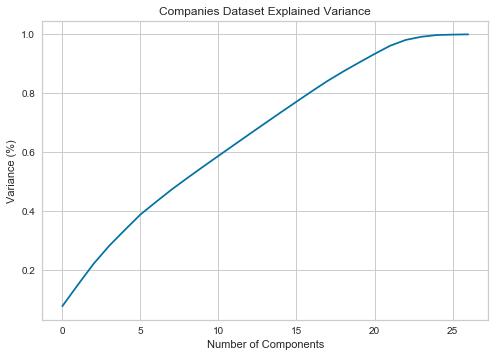

In [15]:
plt.figure()
plt.plot(np.cumsum(pca_alt.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Companies Dataset Explained Variance')
plt.show()

In [16]:
pca_alt = PCA(n_components = 23)
alt30 = pca_alt.fit_transform(complete1_scaled)
print('23 principal components explain:', pca_alt.explained_variance_ratio_.sum(), 'of the data variance')

23 principal components explain: 0.9811376200367439 of the data variance


In [17]:
alt_df = pd.DataFrame(alt30, columns=[f'PC{x+1}' for x in range((pca_alt.n_components_))])

alt_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,-1.005843,0.481199,5.101498,0.089538,-13.541418,-3.067082,3.307921,1.146352,-0.300967,0.139215,...,0.507754,0.578179,-0.212332,-0.044184,-0.878173,-0.592459,0.472801,-0.451458,-1.283281,-15.045729
1,-1.813818,1.306174,8.650017,0.142135,-25.587431,-5.869535,6.377882,1.870509,-0.790759,0.327951,...,0.908642,0.896433,-0.486427,0.279714,0.197316,-0.122635,0.341679,-0.951630,-1.082172,-9.552885
2,-0.565998,-0.025622,2.535041,-0.038812,-5.949170,-3.096502,0.217566,0.827674,0.050900,0.292614,...,0.453284,0.137622,-0.322196,0.290186,0.485188,-1.103649,0.095274,0.812278,0.840421,-7.805763
3,-0.720647,0.419112,3.023505,0.033532,-9.481429,-3.364922,0.556363,1.144766,1.531217,0.113747,...,0.968637,0.210578,-0.444655,-0.531481,0.151787,-1.160301,0.034264,1.171804,1.563625,0.609390
4,-0.317726,0.783534,0.392928,0.007687,-1.268800,-0.397266,-0.039241,-0.026658,0.076277,-0.072112,...,-0.029409,-0.151209,-0.096920,0.106117,0.390310,-0.197276,0.141744,-0.043493,0.378935,0.372608


Evaluating effect of PCA:

- We could reduce the dataset to 23 principal components as opposed to 27 and preserve most of the variance of the data. 
- We will run clustering on PCA data but considering the limited effect of PCA on this data we will focus on non-PCA data.

In [18]:
complete1.head()

,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.dividendGrowthRate5Y,...,metric.freeCashFlowAnnual,metric.longTermDebt/equityAnnual,metric.netInterestCoverageAnnual,metric.payoutRatioAnnual,metric.quickRatioAnnual,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual
0,410825.30,1934379.0,11.284440,19.40911,18.63398,38.718250,37.817770,21.23809,21.89832,11.229900,...,44777.0,101.45760,23.609307,25.570070,1.501290,119.40480,1.486500,1.275840,1.352890,40.134460
1,133155.30,442932.0,6.690699,29.93606,61.20183,52.764357,54.018287,30.06225,25.11008,38.208420,...,55843.0,81.79525,22.797158,23.640280,0.788504,161.45800,1.589900,3.594610,12.762828,7.640894
2,16052.58,388131.4,15.074940,6.57306,7.71885,38.289440,40.990010,4.13586,2.87305,19.595689,...,21653.0,65.27393,18.933590,38.788651,0.863630,67.37995,2.882723,5.395433,28.074190,8.788510
3,58268.48,705031.1,6.973920,5.05381,7.91697,53.188140,53.562780,8.26467,8.60255,2.041380,...,14345.0,82.13450,3.773710,108.115100,0.753100,88.56048,5.342350,7.574650,-1.722560,29.863710
4,-155641.00,3219231.0,170.816300,3.70202,6.06133,47.072970,50.629230,-4.83473,25.37806,12.018900,...,1522.0,434.61910,23.397624,188.957059,0.309640,450.69110,4.390640,8.981560,8.579920,5.362020


# IV. KMeans Clustering - PCA Data

- We use the 'Elbow' method to look for the optimal number of clusters. 
- We don't treat the elbow method as absolute truth but use it as an indicator of where our model potentially fits best.
- We use two variants of the elbow method: Distortion (sum of squared distances from centroid) / clainski_harabasz (ratio of dispersion between / within clusters)
- The elbow method works well for closely clustered data.

In [50]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(4,80))

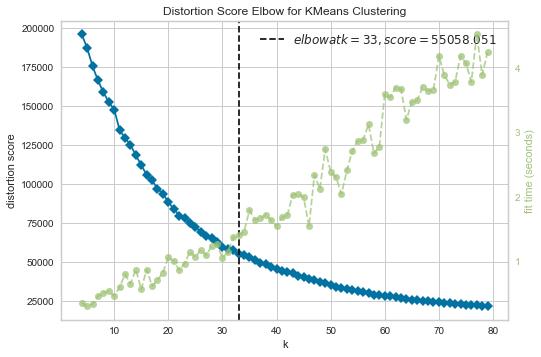

In [51]:
visualizer.fit(alt_df)
visualizer.poof().get_figure()

In [61]:
visualizer1 = KElbowVisualizer(km, k=(4,80), metric ='calinski_harabasz', locate_elbow = True)
visualizer1.fit(alt_df)

Limited results with this second method

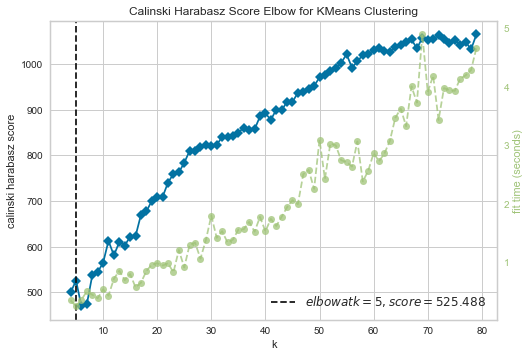

In [63]:
visualizer1.poof().get_figure()

In [19]:
number_clusters = 33
pca_km_alt = KMeans(n_clusters = number_clusters, n_init = 10, random_state =0)
pca_km_alt.fit(alt_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=33, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [20]:
predicted_alt_pca = pca_km_alt.predict(alt_df)

In [21]:
predicted_alt_pca

array([ 3,  3, 24, ..., 17, 17, 17], dtype=int32)

No cluster separation visible within the elected principal components below

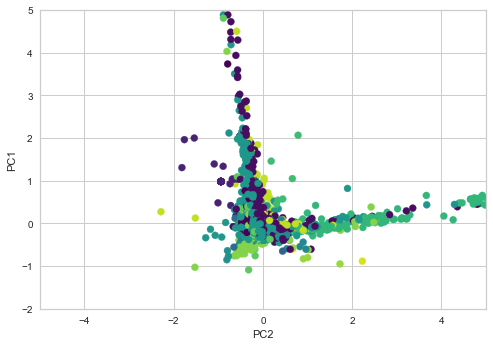

In [22]:
plt.axis([-5,5,-2,5])
plt.ylabel('PC1')
plt.xlabel('PC2')
plt.scatter(alt30[:,0], alt30[:,1], c = predicted_alt_pca, cmap = 'viridis')

From the below we notice clusters that deal with bunched data combined with outliers
 - multidimensional scaling used

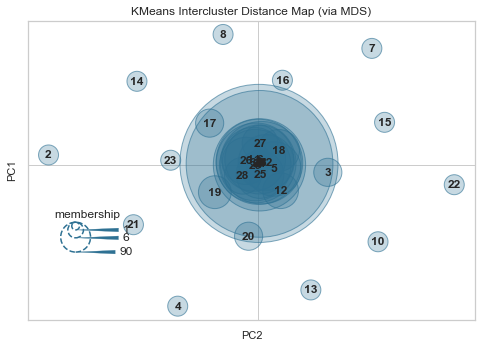

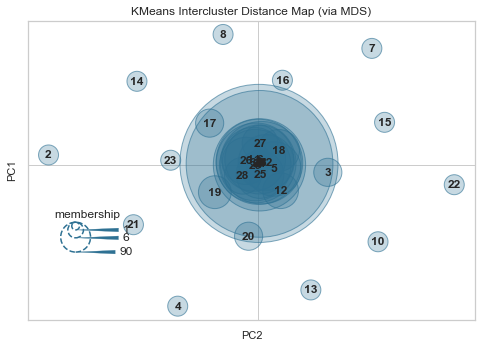

In [14]:
model = KMeans(33)
int_clust_dist = InterclusterDistance(model)
int_clust_dist.fit(alt_df)
int_clust_dist.poof().get_figure()

Adding another dimension to understand data dispersion

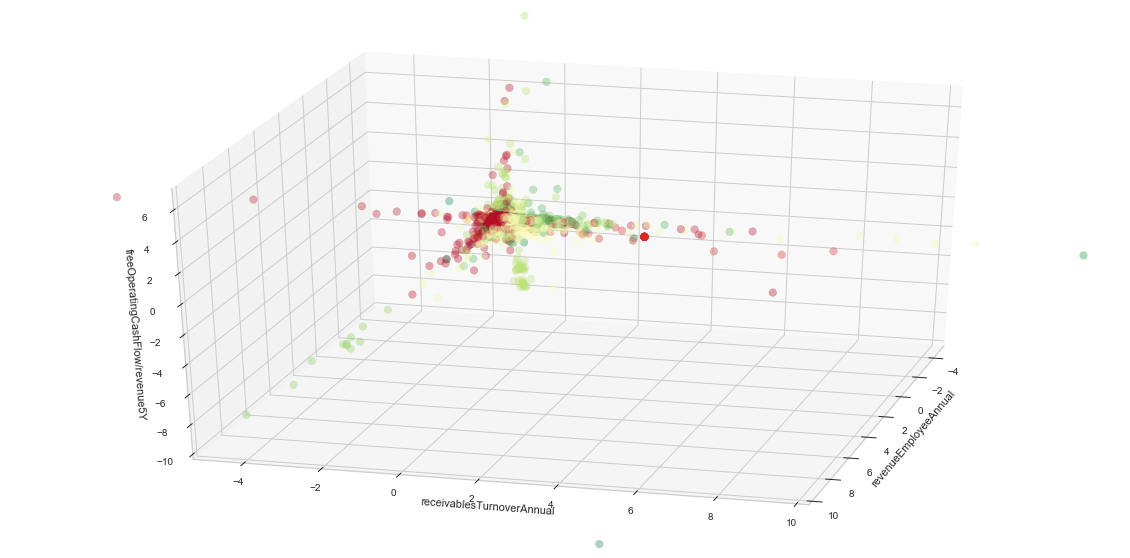

In [15]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('revenueEmployeeAnnual') #check PCA extraction
ax.set_ylabel('receivablesTurnoverAnnual') #check PCA extraction
ax.set_zlabel('freeOperatingCashFlow/revenue5Y') #check PCA extraction
ax.scatter(alt30[:,1], alt30[:,2], alt30[:,3], c=predicted_alt_pca , s=60,cmap="RdYlGn")
ax.set_xlim3d(-5, 10)
ax.set_ylim3d(-5,10)
ax.set_zlim3d(-10,7)
ax.view_init(30, 15)
plt.show()

# V. KMeans Clustering - without PCA data


In [25]:
km = KMeans()
elbow = KElbowVisualizer(km, k=(4,80))

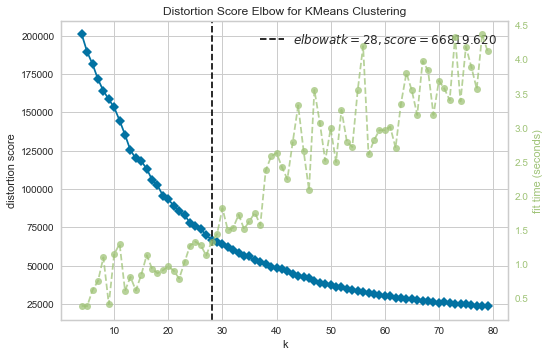

In [27]:
elbow.fit(complete1_scaled)
elbow.poof().get_figure()

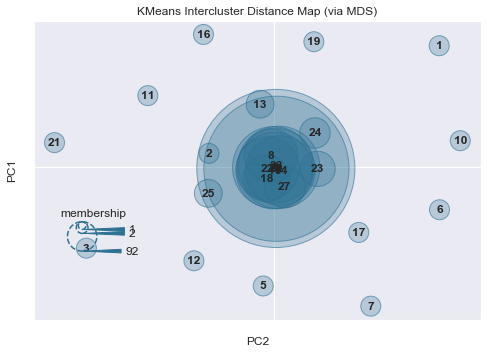

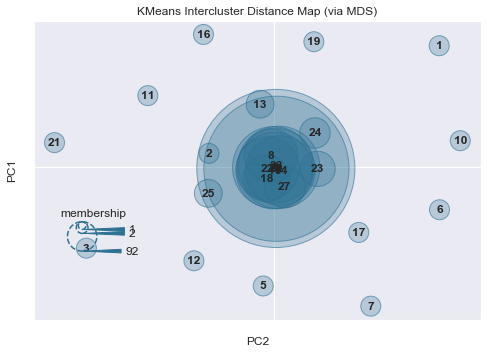

In [36]:
model = KMeans(28)
int_clust_dist_1 = InterclusterDistance(model)
int_clust_dist_1.fit(alt_df)
int_clust_dist_1.poof().get_figure()

From the displays above we understand some of the limitations of using the elbow method to find the 'optimal' number of clusters. 

    - We consider our data and devide to increase the number of clusters to simplify the inspection of clusters


In [23]:
alt_km = KMeans(n_clusters = 100, n_init = 10, random_state =0)
alt_km.fit(complete1_scaled)
pred_alt = alt_km.predict(complete1_scaled)
alt_df_2 = pd.DataFrame(pred_alt, columns = ['company cluster'])
alt_df_2.reset_index(inplace = True)
alt_df_2['companies'] = 1

In [24]:
clusters = pd.pivot_table(alt_df_2,  values = 'companies', index = 'company cluster', aggfunc = np.sum)
clusters = clusters.reset_index().sort_values(by = 'companies', ascending = False)

Text(0.5, 1.0, 'KMeans Clusters')

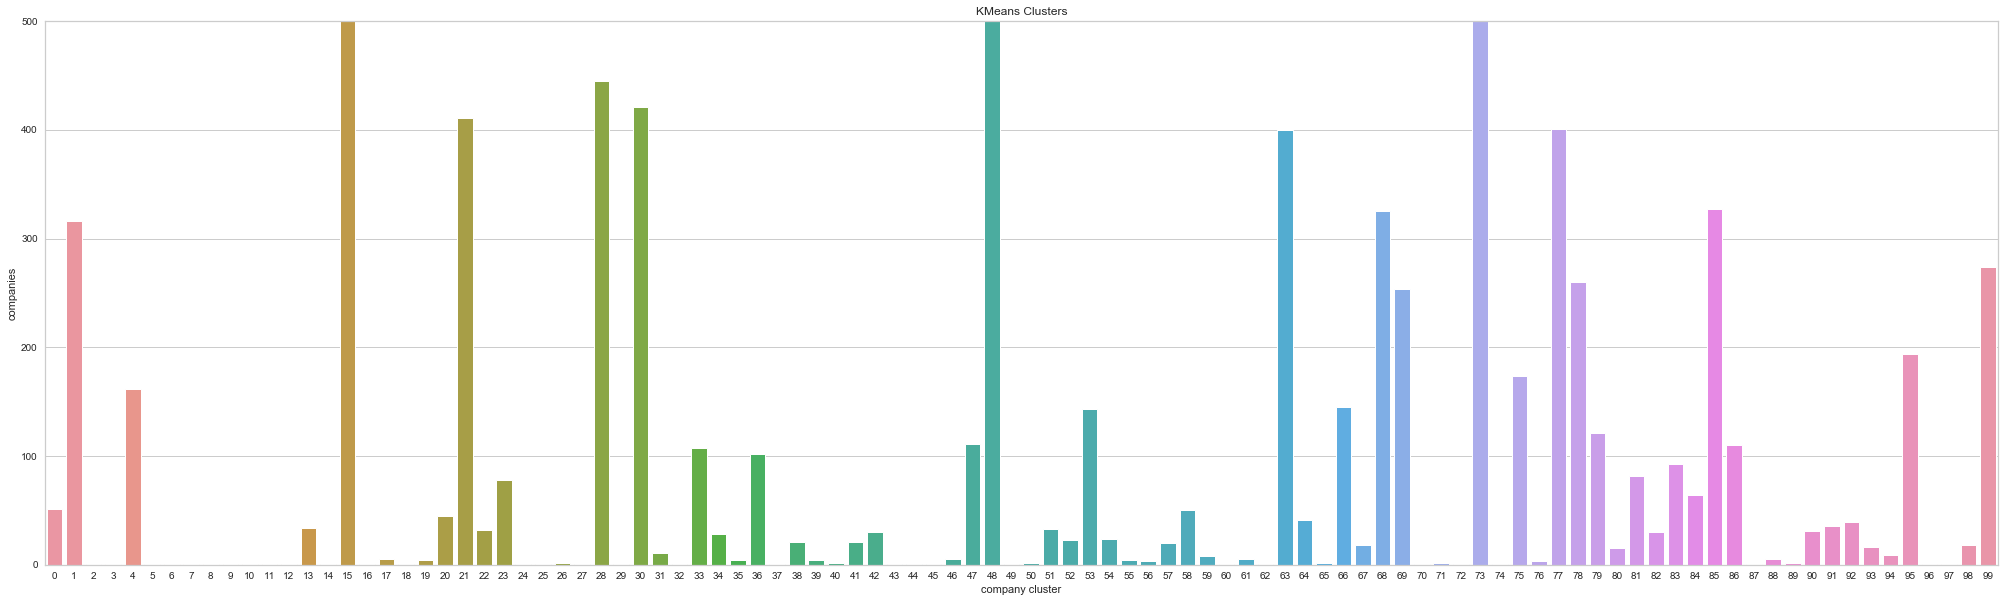

In [25]:
f, ax = plt.subplots(figsize=(35, 10))
plt.axis([0,100,0,500])
sns.set(style = "darkgrid")
sns.barplot(x='company cluster', y = 'companies', data = clusters).set_title('KMeans Clusters')

Plotting some of our clusters shows the difficulty in displaying multidimensional data. 

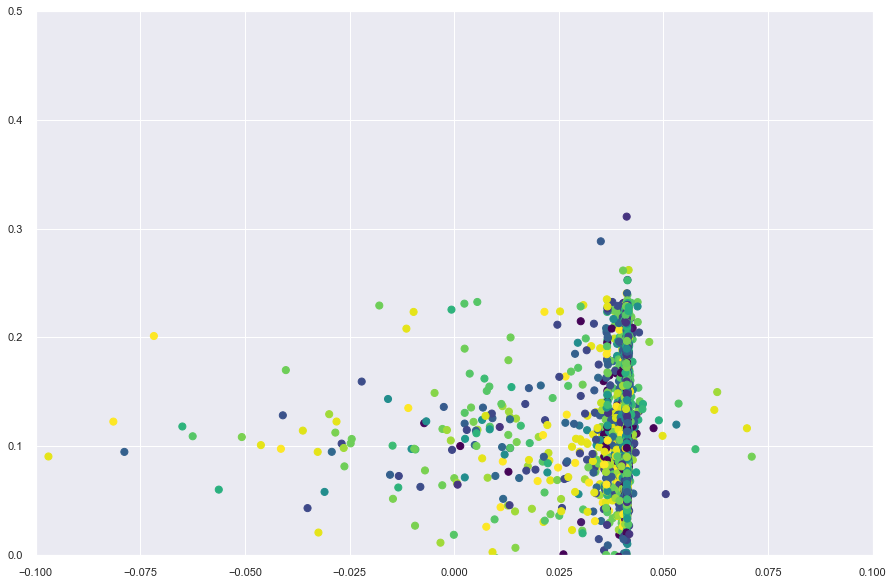

In [78]:
plt.figure(figsize = [15,10])
plt.axis([-0.1,0.1,0,0.5])
plt.scatter(complete1_scaled[:, 4], 
            complete1_scaled[:, 5], c=pred_alt, s=50, cmap='viridis');

Adding another dimension to our plots highlights a slightly more pronounced separation of the clusters

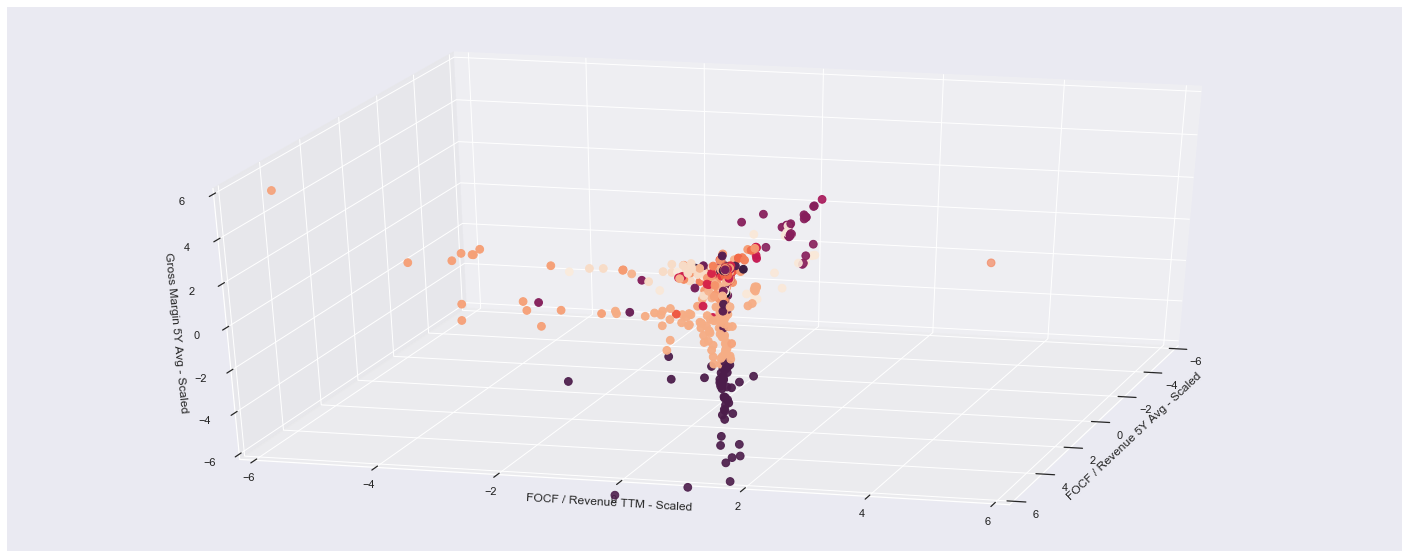

In [79]:
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('FOCF / Revenue 5Y Avg - Scaled')
ax.set_ylabel('FOCF / Revenue TTM - Scaled')
ax.set_zlabel('Gross Margin 5Y Avg - Scaled')
ax.scatter(complete1_scaled[:,3], complete1_scaled[:,4], complete1_scaled[:,5], c=pred_alt, s=60)
ax.set_xlim3d(-6, 6)
ax.set_ylim3d(-6,6)
ax.set_zlim3d(-6,6)
ax.view_init(30, 15)
plt.show()

## Inspecting cluster consituents

In [26]:
findata_w_clusters = pd.merge(df, alt_df_2, left_index = True, right_index = True)

In [27]:
findata_w_clusters.drop(columns = ['index', 'companies'], inplace = True)

We have tagged back each of the companies to its assigned cluster

In [28]:
findata_w_clusters.iloc[:,1:29]

,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.dividendGrowthRate5Y,...,metric.longTermDebt/equityAnnual,metric.netInterestCoverageAnnual,metric.payoutRatioAnnual,metric.quickRatioAnnual,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,company cluster
0,410825.3000,1934379.000,11.284440,19.40911,18.63398,38.718250,37.817770,21.23809,21.89832,11.229900,...,101.457600,23.609307,25.570070,1.501290,119.404800,1.486500,1.275840,1.352890,40.134460,59
1,133155.3000,442932.000,6.690699,29.93606,61.20183,52.764357,54.018287,30.06225,25.11008,38.208420,...,81.795250,22.797158,23.640280,0.788504,161.458000,1.589900,3.594610,12.762828,7.640894,65
2,16052.5800,388131.400,15.074940,6.57306,7.71885,38.289440,40.990010,4.13586,2.87305,19.595689,...,65.273930,18.933590,38.788651,0.863630,67.379950,2.882723,5.395433,28.074190,8.788510,59
3,58268.4800,705031.100,6.973920,5.05381,7.91697,53.188140,53.562780,8.26467,8.60255,2.041380,...,82.134500,3.773710,108.115100,0.753100,88.560480,5.342350,7.574650,-1.722560,29.863710,13
4,-155641.0000,3219231.000,170.816300,3.70202,6.06133,47.072970,50.629230,-4.83473,25.37806,12.018900,...,434.619100,23.397624,188.957059,0.309640,450.691100,4.390640,8.981560,8.579920,5.362020,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,-849453.9355,1670097.475,12.043480,4.81754,47.59596,84.209640,84.556760,39.95187,47.65050,-1.389070,...,0.595290,8.423310,106.726900,4.053382,17.737900,3.204510,3.577780,-47.469440,141.611651,21
8643,-810546.1370,7293925.835,202.307575,-3.03933,-0.16750,82.212780,65.077754,106.46740,106.24440,11.081378,...,1.946025,-754.042359,63.378094,2.305304,4.867440,7.627042,15.961122,-6.547941,32.584788,79
8644,71174.8035,561054.520,9.350430,-39.89987,-169.99190,24.898900,19.561240,-76.23400,-10.26382,0.707898,...,0.475960,-0.369370,42.401914,0.166510,30.890050,4.194674,14.894328,35.637490,0.169430,85
8645,29784.9700,428386.900,5.106880,0.05188,1.38347,62.201700,64.207170,6.95282,8.72242,-0.471700,...,90.966390,33.200000,130.026800,0.713080,98.704480,3.974600,4.820940,2.784790,15.404580,73


Let's compare now two clusters and see what differentiates them
   
   - We select smaller clusters to simplify our observation process.

In [29]:
cl51 = findata_w_clusters.loc[findata_w_clusters['company cluster'] == 51].describe()
cl52 = findata_w_clusters.loc[findata_w_clusters['company cluster'] == 52].describe()
cl51

,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.dividendGrowthRate5Y,...,metric.longTermDebt/equityAnnual,metric.netInterestCoverageAnnual,metric.payoutRatioAnnual,metric.quickRatioAnnual,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,company cluster
count,3.300000e+01,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,...,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.0
mean,-5.302821e+05,1.914792e+06,8.474326,-21499.063617,-9779.243192,-55.323360,-493.251152,-1583.440912,-17613.279771,2.836253,...,7.608829,-369.973775,61.667637,29.810565,8.266651,4.097309,10.350640,-2.249667,34.693418,51.0
std,2.152768e+06,6.885623e+06,9.148985,47039.609835,27239.989865,274.087658,2622.672681,6348.761416,43772.497198,6.122705,...,23.479760,1027.464679,50.909683,12.836356,23.467177,2.483167,6.371833,26.482742,61.558952,0.0
min,-1.054478e+07,1.021814e+05,0.033760,-146882.078879,-106323.835838,-1187.922249,-15004.790000,-36136.040000,-186102.909860,-7.303742,...,0.000000,-5604.891000,0.000000,18.769520,0.000000,0.000000,2.307690,-60.717480,0.176470,51.0
25%,-8.329097e+05,2.538571e+05,2.591360,-15206.711234,-826.426250,8.684900,2.471610,-649.099519,-14534.555627,-1.319086,...,0.000000,-196.237400,31.686349,22.527226,0.000000,2.268492,5.709156,-14.753627,2.493520,51.0
50%,-2.727166e+05,5.189356e+05,6.832550,-229.828100,-111.930200,32.865080,32.443616,-69.871470,-81.480740,2.256413,...,0.000000,-37.165511,45.593387,23.860460,0.000000,3.684483,6.819687,-3.544462,8.475484,51.0
75%,2.888385e+04,9.280846e+05,10.978789,-12.755680,-19.837750,46.123575,62.412080,1.173464,4.885410,5.715392,...,1.012970,0.613710,91.436598,33.597510,2.141340,4.474978,13.870685,13.461884,32.752814,51.0
max,5.448502e+06,4.009467e+07,48.323170,45.621750,77.506330,95.037220,90.566340,523.188800,1597.257815,22.247617,...,94.048950,240.750000,192.246437,71.400520,94.159450,10.777522,24.924710,61.680690,280.376600,51.0


In [30]:
cl51_mean = cl51[1:2].T.round(1).reset_index()
cl52_mean = cl52[1:2].T.round(1).reset_index()

In [31]:
cl5152 = pd.merge(cl51_mean, cl52_mean, on = 'index').rename(columns = {'index': 'metric', 'mean_x':'cl51_average', 'mean_y':'cl52_average'})

Some Observations at the cluster level: 

   - Outliers in the data are skewing some of the metrics (e.g. Average Net Profit Margin over 5 year-period)
   - Overall cl52 seems to contain more high gross margin businesses with high amounts of debt (some of the metrics in CL51 indicates some potentially distressed companies)
   - Both clusters seem to suffer from high depreciation & amortization + interest / tax expenses which suggest a high amount of asset and asset servicing costs




In [32]:
cl5152

,metric,cl51_average,cl52_average
0,metric.netIncomeEmployeeAnnual,-530282.1,-185388.1
1,metric.revenueEmployeeAnnual,1914791.5,1231905.6
2,metric.receivablesTurnoverAnnual,8.5,12.7
3,metric.freeOperatingCashFlow/revenue5Y,-21499.1,-1092.3
4,metric.freeOperatingCashFlow/revenueTTM,-9779.2,-46.6
5,metric.grossMargin5Y,-55.3,34.3
6,metric.grossMarginAnnual,-493.3,50.8
7,metric.netProfitMargin%Annual,-1583.4,-2.1
8,metric.netProfitMargin5Y,-17613.3,-1403.2
9,metric.dividendGrowthRate5Y,2.8,0.0


In [33]:
cl52_comp = findata_w_clusters.loc[findata_w_clusters['company cluster'] == 52]

Peek into Cluster 52: 

 - Main metric contributing to cl52 seems to be Gross Margin
 - Sectors include: Industrials, Financial Servicem Real Estate and Entertainment
 - cl52 could serve as a basic screen if you're scouting for high gross margin businesses

In [37]:
cl52_comp = cl52_comp.merge(tickers, left_on = 'symbol', right_on = 'Ticker')

In [41]:
movecol(cl52_comp, cols_to_move = ['Name', 'Category Name'], ref_col = 'symbol', place = 'After')

,symbol,Name,Category Name,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,...,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,company cluster,Unnamed: 0,Ticker,Exchange,Country
0,PCG,PG&E Corporation,Electric Utilities,-3.251915e+05,7.288936e+05,14.068990,-9.838400,-8.739560,50.649986,51.153900,...,479.45870,4.285656,5.857643,5.488180,20.905910,52,4048,PCG,NYQ,USA
1,CSBR,iShares MSCI Brazil ETF USD Acc,Biotechnology,1.236715e+03,2.615169e+05,6.526890,-26.045140,-0.713990,38.572330,47.297450,...,0.71492,2.470324,8.854091,28.940700,70.691124,52,4913,CSBR,NCM,USA
2,CTO,Consolidated-Tomoka Land Co.,Real Estate Development,-8.116153e+04,1.570093e+06,19.543290,-163.223800,-303.712300,75.341960,84.191210,...,100.63240,0.385910,2.320190,27.845690,30.632314,52,5291,CTO,ASE,USA
3,LYV,"Live Nation Entertainment, Inc.",Entertainment - Diversified,1.182120e+04,1.154797e+06,12.324620,3.599470,0.900210,29.978930,30.598340,...,288.79380,4.537568,16.576292,20.677480,558.870500,52,7106,LYV,NYQ,USA
4,LTS,Ladenburg Thalmann Financial Services Inc.,Investment Brokerage - National,2.337323e+04,9.623909e+05,38.317500,-1.066010,-0.795420,24.417820,27.066010,...,101.39100,0.443990,1.428570,16.156640,26.955133,52,8363,LTS,ASE,USA
5,GSIT,"GSI Technology, Inc.",Semiconductor - Broad Line,1.009288e+03,3.187988e+05,8.160720,0.980510,1.225420,53.242300,61.430290,...,0.00000,2.790359,7.295813,22.391800,3.535970,52,9587,GSIT,NMS,USA
6,HR,Healthcare Realty Trust Incorporated,REIT - Healthcare Facilities,1.365331e+05,1.638669e+06,41.435950,-59.128550,-82.323300,62.975650,61.725330,...,75.37364,3.932620,4.748710,25.561370,28.740327,52,10462,HR,NYQ,USA
7,HLIT,Harmonic Inc.,Communication Equipment,-5.076264e+03,3.452219e+05,4.283660,-0.246560,5.204360,51.988840,55.700540,...,60.06750,2.460934,7.890897,0.517220,6.527830,52,10538,HLIT,NMS,USA
8,PTC,PTC Inc.,Technical & System Software,-4.514591e+03,2.064334e+05,5.002120,13.959280,18.218290,72.912200,74.086500,...,55.66848,4.083670,8.871148,20.574030,20.893569,52,11869,PTC,NMS,USA
9,LIQT,"LiqTech International, Inc.",Pollution & Treatment Controls,-1.061043e+06,1.369629e+06,5.945860,-14.759235,-603.160600,15.223780,21.945050,...,0.89996,2.301365,8.701411,41.291660,5.290080,52,15634,LIQT,ASE,USA


## KMeans Preliminary Conclusions:

   - KMeans clusters can give us some high level information on specific comapany groups and provide some ground to do a deeper dive
   - KMeans is sensitive to outliers and we see it in our results where even a large number of smaller clusters are still influenced by outliers. This limits the conclusions we are able to draw.
   - To remediate the issues above we should run multiple iterations of KMeans and focus on a smaller and more consistent set of data

# VI. Agglomerative Clustering (AGNES)

 - We decide to use an alternative method of clustering -> Agglomerative Clustering 
 - Fewer hidden assumptions in hierarchical clustering 
 - We have more flexibility in choosing the optimal number of clusters
 - This method is more computationally intensive but provides more intuitive results

In [44]:
clustering_alt = AgglomerativeClustering().fit_predict(complete1_scaled)

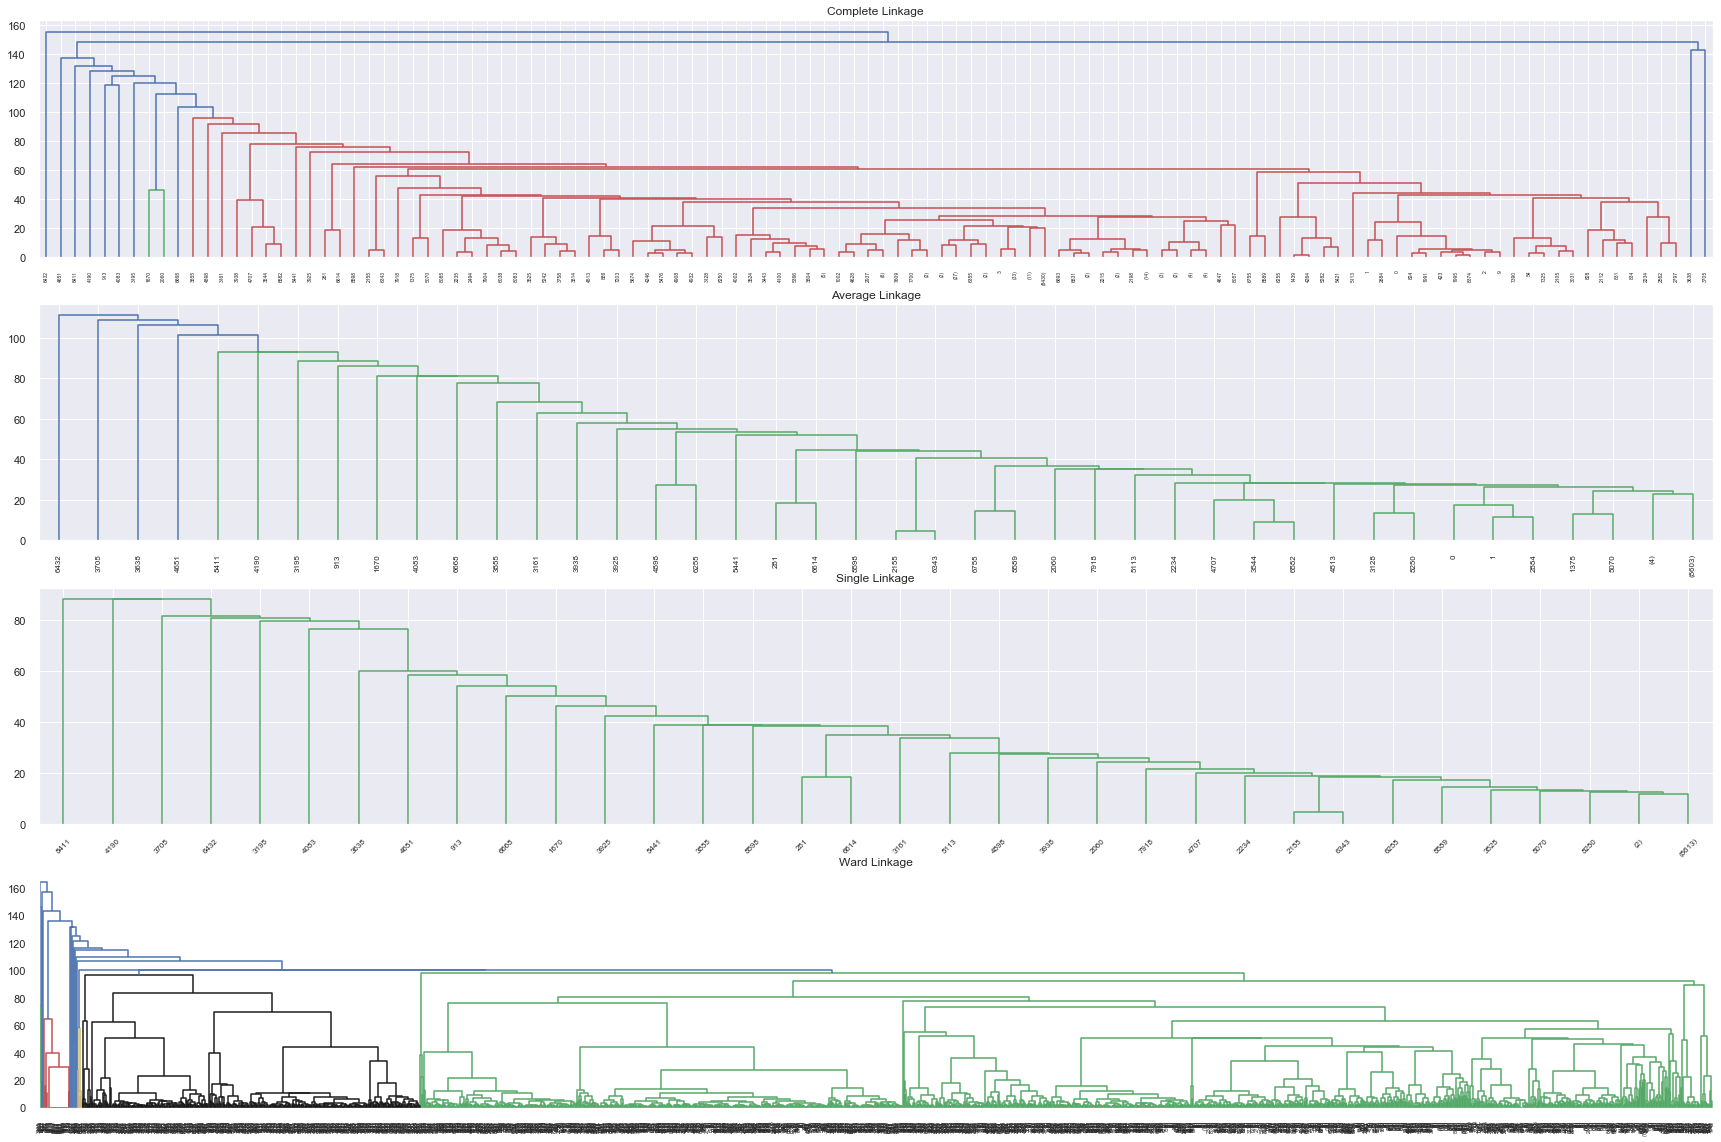

In [47]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(30,20))

# This time we define linkage through functions instead of an argument
for link, cluster, ax in zip([shc.complete(complete1_scaled),
                                 shc.average(complete1_scaled),
                                 shc.single(complete1_scaled),
                                 shc.ward(complete1_scaled)],
                                ['c1','c2','c3','c4'],
                                [ax1,ax2,ax3, ax4]):
    shc.dendrogram(link, ax=ax, color_threshold=100, truncate_mode='level',
                  )

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')
ax4.set_title('Ward Linkage');
plt.savefig('visualizations/dendrogram.png')

Use Cophenetic Correlation to identify best linkage distance metric 

   - Choose the linkage with the highest resulting value as it measures how well the dendogram preserves pairwise distance between observations

In [49]:
methods = ['complete', 'single', 'ward', 'average']

In [50]:
for m in methods: 
    Z = linkage(complete1_scaled, m)
    c, coph_dists = cophenet(Z, pdist(complete1_scaled))
    print(m,':',c)

complete : 0.8706267192010227
single : 0.929933289842198
ward : 0.4101012985062367
average : 0.9835433813269311


In [52]:
main_link = linkage(complete1_scaled, 'average')

Each main_link[i] gives us an array for the clusters that are merged at each iteration of the model

   - The first / second number of each array corresponds to the index or a merged cluster of indices
    
   - The Third number of each array is the distance between the merged clusters
    
   - The Fourth number of each array is the number of samples (companies) in the cluster created


In [53]:
main_link[0:10]

array([[7.091e+03, 7.092e+03, 0.000e+00, 2.000e+00],
       [7.093e+03, 8.647e+03, 0.000e+00, 3.000e+00],
       [7.094e+03, 8.648e+03, 0.000e+00, 4.000e+00],
       [7.095e+03, 8.649e+03, 0.000e+00, 5.000e+00],
       [7.096e+03, 8.650e+03, 0.000e+00, 6.000e+00],
       [7.097e+03, 8.651e+03, 0.000e+00, 7.000e+00],
       [7.098e+03, 8.652e+03, 0.000e+00, 8.000e+00],
       [7.099e+03, 8.653e+03, 0.000e+00, 9.000e+00],
       [7.100e+03, 8.654e+03, 0.000e+00, 1.000e+01],
       [7.101e+03, 8.655e+03, 0.000e+00, 1.100e+01]])

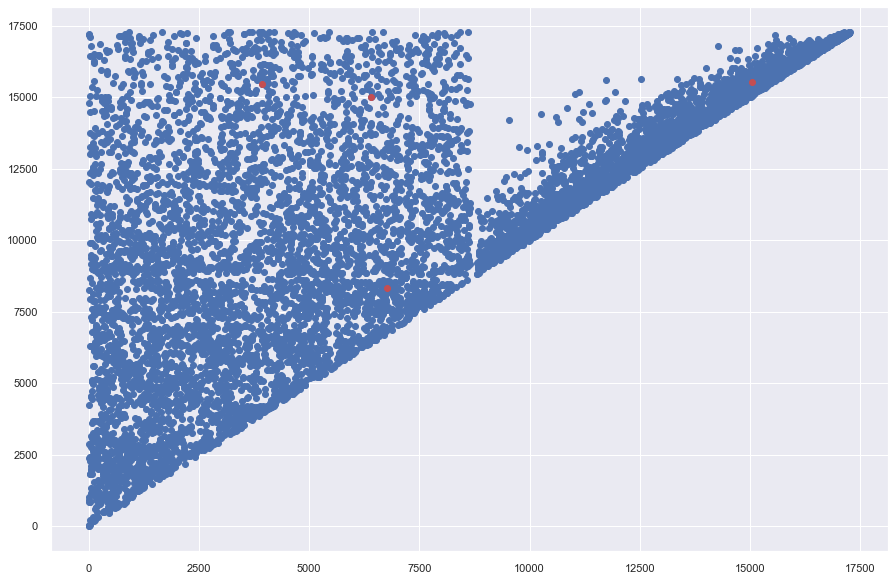

In [56]:
idx = [7091,7092,7093,7094]
plt.figure(figsize = (15,10))
plt.scatter(main_link[:,0], main_link[:,1])
plt.scatter(main_link[idx,0],main_link[idx,1], c = 'r')
plt.show()

Dendogram Truncation - Showing the remaining 100 clusters in the hierarchy

-  Risk here is random selection / intuition based selection 

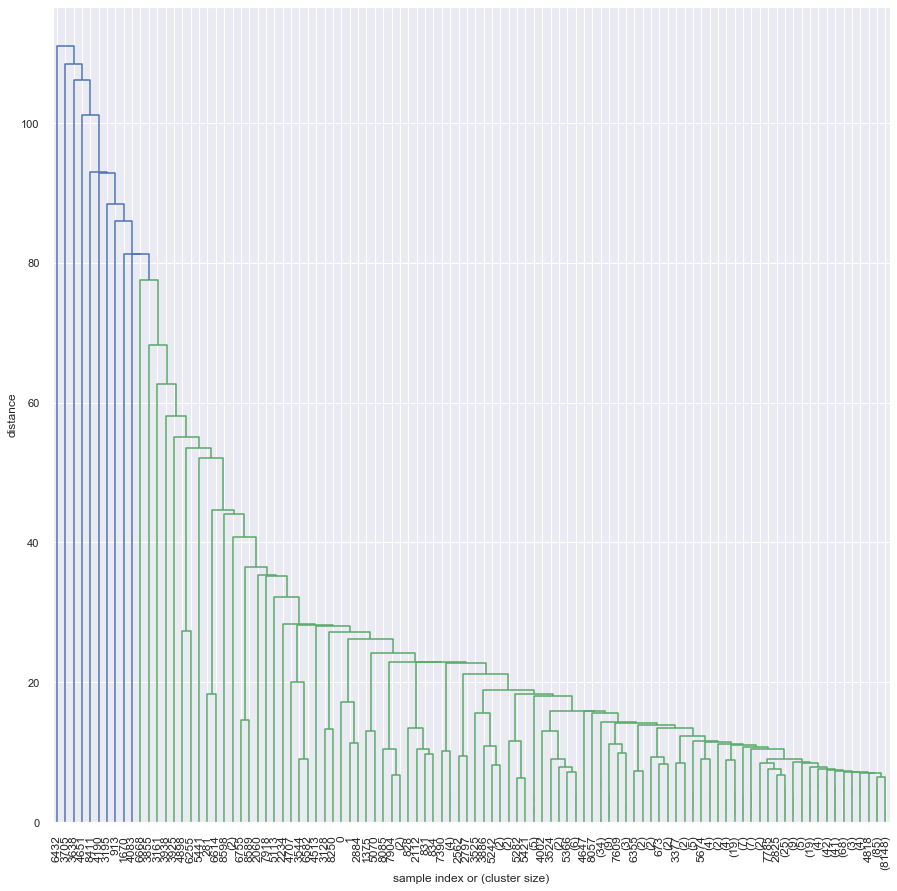

In [57]:
plt.figure(figsize = (15,15))
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    main_link,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

Retrieving Clusters - Our data has companies very close together complemented by outliers. We set the limit distance to a very low value to allow us to dive into the components of the cluster where we hope to extract insights. 

In [62]:
clust_dist = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10]

print('Dendogram Truncation based on Euclidian Distance')

for values in clust_dist: 
    clusters = fcluster(main_link, values, criterion = 'distance')
    clh = pd.DataFrame(clusters, columns = ['cluster_ID'])
    clh['comp_per_clust'] = 1
    piv = pd.pivot_table(clh, 'comp_per_clust', 'cluster_ID', aggfunc = np.sum)
    piv1 = piv.reset_index().sort_values('comp_per_clust', ascending = False)
    print('----------------------------------------------')
    print('#Unique Clusters: ', piv1.cluster_ID.value_counts().sum())
    print('Company per cluster metrics:')
    print('cluster distance of', values,'yields -->', 'median:',piv1.comp_per_clust.median(),'; mean:',piv1.comp_per_clust.mean(),'; min:',piv1.comp_per_clust.min(),'; max:',piv1.comp_per_clust.max())
    print('----------------------------------------------')

Dendogram Truncation based on Euclidian Distance
----------------------------------------------
#Unique Clusters:  8491
Company per cluster metrics:
cluster distance of 0.1 yields --> median: 1.0 ; mean: 1.0183723942998468 ; min: 1 ; max: 32
----------------------------------------------
----------------------------------------------
#Unique Clusters:  6644
Company per cluster metrics:
cluster distance of 0.5 yields --> median: 1.0 ; mean: 1.301475015051174 ; min: 1 ; max: 34
----------------------------------------------
----------------------------------------------
#Unique Clusters:  2750
Company per cluster metrics:
cluster distance of 1 yields --> median: 1.0 ; mean: 3.1443636363636362 ; min: 1 ; max: 398
----------------------------------------------
----------------------------------------------
#Unique Clusters:  1323
Company per cluster metrics:
cluster distance of 1.5 yields --> median: 1.0 ; mean: 6.535903250188965 ; min: 1 ; max: 2313
---------------------------------------

Elect a distance of 2 for our truncation / returns each cluster 'id' for companies

In [61]:
clusters_f = fcluster(main_link, 2, 'distance')
clusters_f

array([ 16,  14, 112, ..., 667, 692, 692], dtype=int32)

In [64]:
cls_id = pd.DataFrame(clusters_f, columns = ['comp_clust_id'])

In [84]:
agglo_results = pd.merge(df, cls_id, left_index = True, right_index = True).merge(tickers, left_on ='symbol', right_on = 'Ticker')
agglo_results['count'] = 1

In [85]:
movecol(agglo_results.drop(columns =['Unnamed: 0']), cols_to_move = ['Name', 'Category Name'], ref_col = 'symbol', place = 'After').head()

,symbol,Name,Category Name,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,...,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,comp_clust_id,Ticker,Exchange,Country,count
0,AAPL,Apple Inc.,Electronic Equipment,410825.30,1934379.0,11.284440,19.40911,18.63398,38.718250,37.817770,...,119.40480,1.486500,1.275840,1.352890,40.134460,16,AAPL,NMS,USA,1
1,BAC,Bank of America Corporation,Money Center Banks,133155.30,442932.0,6.690699,29.93606,61.20183,52.764357,54.018287,...,161.45800,1.589900,3.594610,12.762828,7.640894,14,BAC,NYQ,USA,1
2,AMZN,"Amazon.com, Inc.",Catalog & Mail Order Houses,16052.58,388131.4,15.074940,6.57306,7.71885,38.289440,40.990010,...,67.37995,2.882723,5.395433,28.074190,8.788510,112,AMZN,NMS,USA,1
3,T,AT&T Inc.,Telecom Services - Domestic,58268.48,705031.1,6.973920,5.05381,7.91697,53.188140,53.562780,...,88.56048,5.342350,7.574650,-1.722560,29.863710,56,T,NYQ,USA,1
4,MO,"Altria Group, Inc.",Cigarettes,-155641.00,3219231.0,170.816300,3.70202,6.06133,47.072970,50.629230,...,450.69110,4.390640,8.981560,8.579920,5.362020,664,MO,NYQ,USA,1


We can notice are more evenly split cluster base vs KMeans clustering with the added customization of AGNES

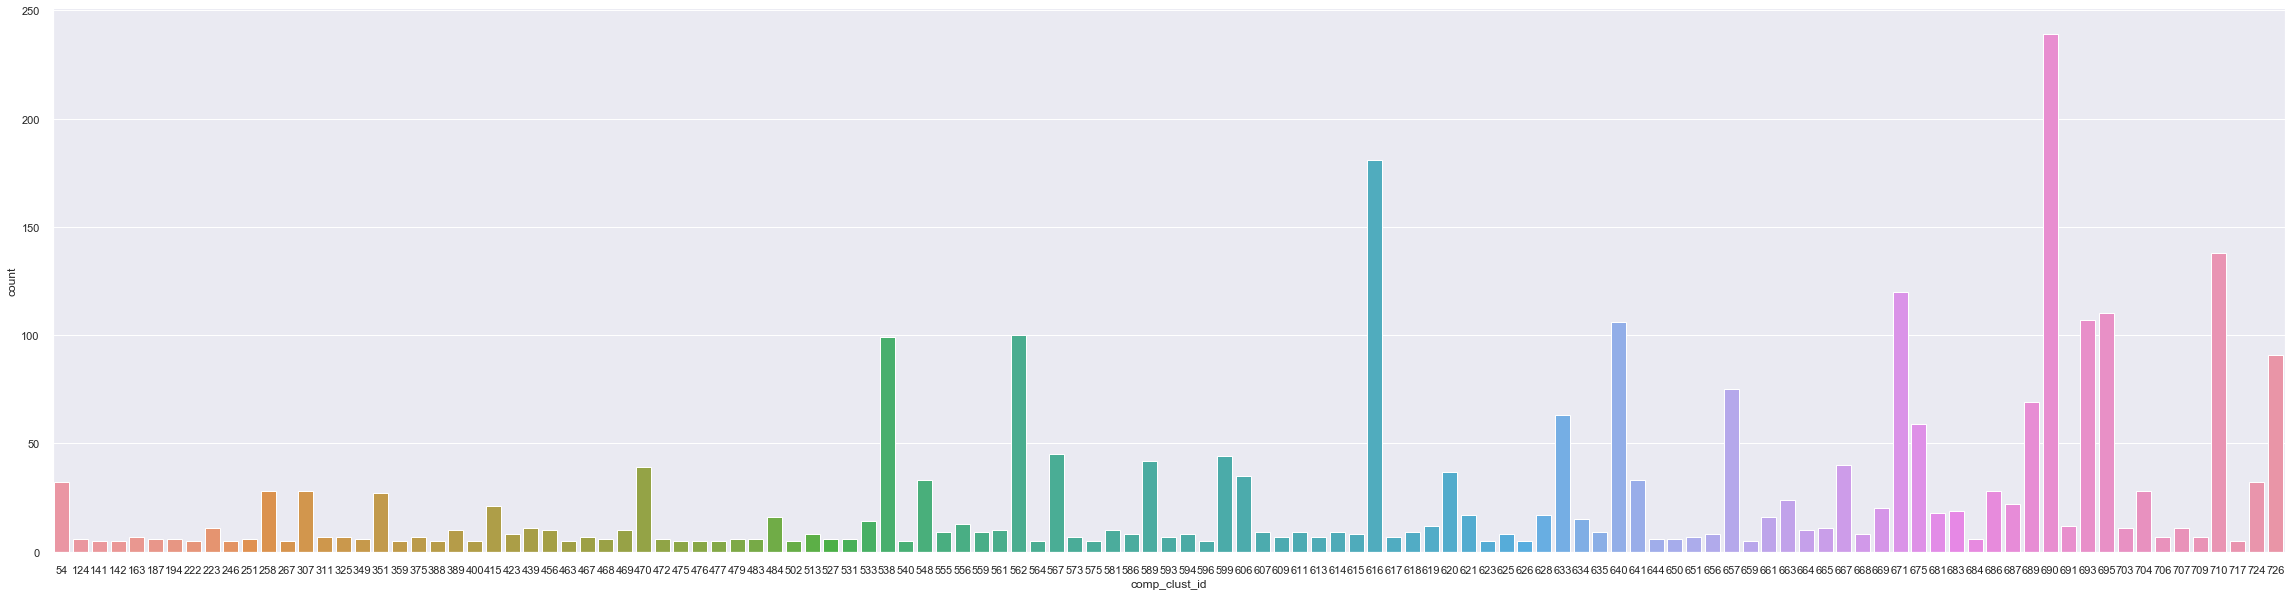

In [86]:
clust_count = agglo_results.pivot_table('count', index = ['comp_clust_id'], aggfunc = np.sum).reset_index()
clust_count = clust_count.query('5 <= count <=300')
f, ax = plt.subplots(figsize=(40, 10))
sns.set(style = "darkgrid")
sns.barplot(x='comp_clust_id', y = 'count', data = clust_count)

## Cluster Deep Dive 

In [87]:
cl484 = agglo_results.loc[agglo_results['comp_clust_id'] == 484].describe()
cl621 = agglo_results.loc[agglo_results['comp_clust_id'] == 621].describe()

In [88]:
cl484_mean = cl484[1:2].T.round(1).reset_index()
cl621_mean = cl621[1:2].T.round(1).reset_index()

In [89]:
cl_combined = pd.merge(cl484_mean, cl621_mean, on = 'index').rename(columns = {'index': 'metric', 'mean_x':'cl484_average', 'mean_y':'cl621_average'})

Some initial observations:
    
   - Large disparity in profitability / financial profile across the two clusters 
   - Clusters appear to display for a fairer representation as outliers should not be as prominent with this clustering method
   - cl621 seems to be a cluser composed of financially strong cluster:
      - High average gross margin ~45%
      - FOCF growth ~ 26.9% 
      - P/E ratio is lower than the other cluster at 24
      - strong metrics are also companied by large growth in debt 42% CAGR
 

In [91]:
cl_combined[0:27]

,metric,cl484_average,cl621_average
0,metric.netIncomeEmployeeAnnual,-136513.9,-129350.6
1,metric.revenueEmployeeAnnual,910381.5,1584241.4
2,metric.receivablesTurnoverAnnual,5.7,37.4
3,metric.freeOperatingCashFlow/revenue5Y,-3916.7,-26.7
4,metric.freeOperatingCashFlow/revenueTTM,-1625.6,-26.2
5,metric.grossMargin5Y,14.1,47.4
6,metric.grossMarginAnnual,-28.0,45.1
7,metric.netProfitMargin%Annual,-1261.9,13.7
8,metric.netProfitMargin5Y,-1665.5,15.3
9,metric.dividendGrowthRate5Y,3.4,2.6


Ploting a correlation matrix could provide us some additional details of the relationships of metrics in cluster

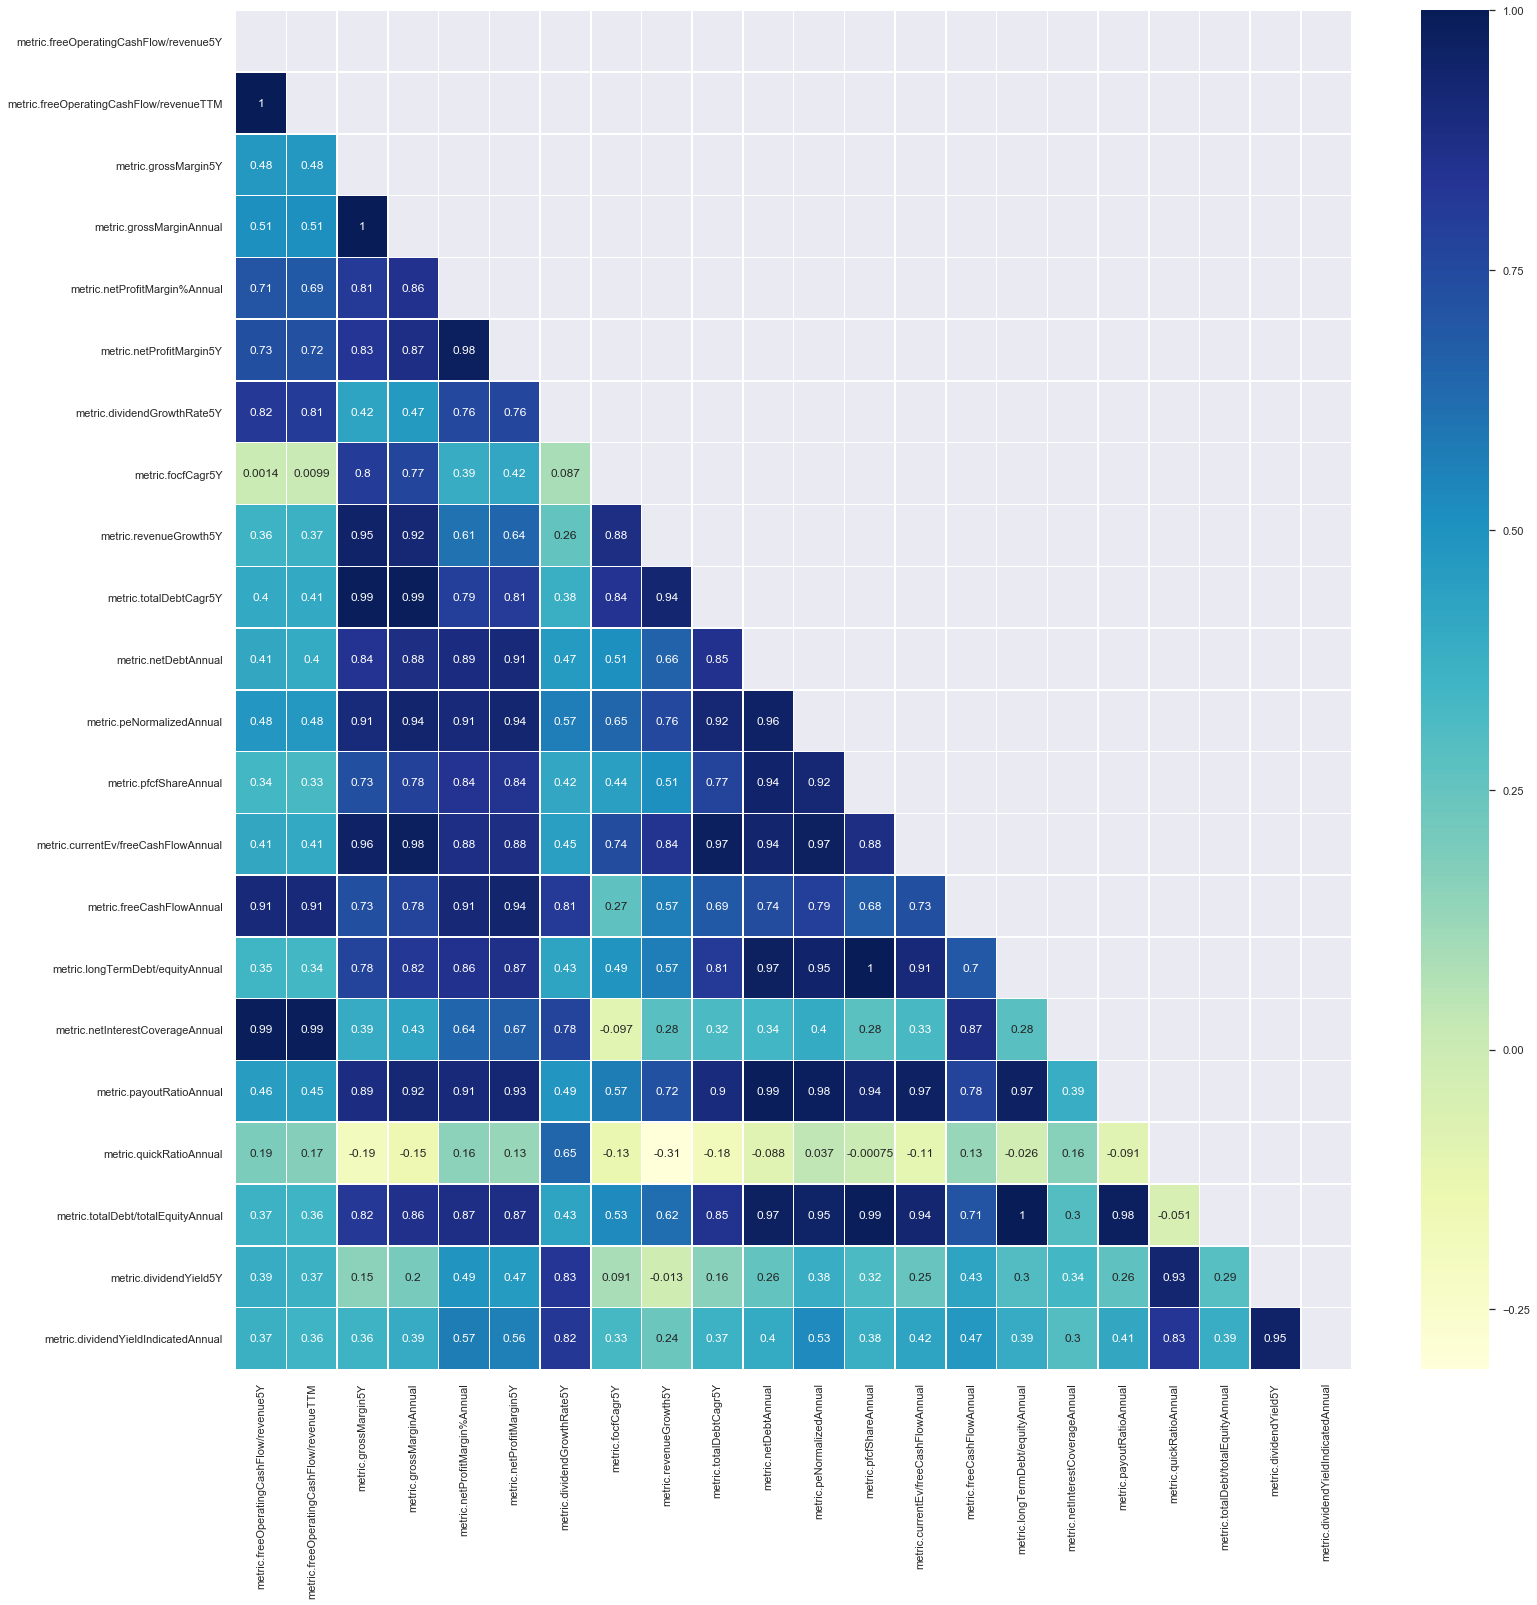

In [110]:
plt.figure(figsize = [25,25])
corr = cl621.iloc[:,3:25].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cl621_corr = sns.heatmap(corr, mask = mask, annot=True, linewidths = .5, cmap = 'YlGnBu');

A few points from the heatmap: 

   - high gross margin within the cluster is correlated with debt growth 
   - Higher P/E ratios have higher debt and higher gross margin - opportunity to study companies with lower P/E and debt 


In [95]:
cl621_comp = agglo_results.loc[agglo_results['comp_clust_id'] == 621]
movecol(cl621_comp, cols_to_move = ['Name', 'Category Name'], ref_col = 'symbol', place = 'After')

,symbol,Name,Category Name,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,...,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,comp_clust_id,Unnamed: 0,Ticker,Exchange,Country,count
1448,LAND,Gladstone Land Corporation,REIT - Diversified,5.034286e+04,1.162629e+06,13.298564,-492.078500,-626.724500,86.018620,85.142040,...,4.413800,4.614990,29.779620,8.054559,621,4752,LAND,NGM,USA,1
2361,VBTX,"Veritex Holdings, Inc.",Regional - Southwest Banks,1.809352e+05,6.284686e+05,7.756587,20.708490,22.053010,49.939957,48.546169,...,2.554241,4.945450,27.837190,24.208398,621,10607,VBTX,NGM,USA,1
2368,NMIH,"NMI Holdings, Inc.",Surety & Title Insurance,5.502624e+05,1.184365e+06,18.071260,49.114330,53.549450,38.174255,38.347540,...,3.133563,3.914156,3.906480,79.707650,621,10621,NMIH,NGM,USA,1
3930,CMA.AX,Centuria Metropolitan REIT,REIT - Diversified,9.423055e+05,1.827040e+06,197.813400,8.601400,4.138540,51.322858,55.406486,...,6.617880,5.979380,7.110915,11.467957,621,54307,CMA.AX,ASX,Australia,1
5271,SOT-UN.TO,Slate Office REIT,Asset Management,8.868095e+04,6.222544e+05,51.776580,5.921720,7.603930,47.424070,46.722810,...,9.989110,11.684210,20.047110,11.603574,621,17422,SOT-UN.TO,TOR,Canada,1
5326,TNT-UN.TO,True North Commercial Real Estate Investment T...,Gold,4.792902e+04,1.159544e+06,46.887030,28.270960,25.546460,59.684820,58.300530,...,9.617880,13.054950,10.271723,80.530938,621,43066,TNT-UN.TO,TOR,Canada,1
5446,FDEV.L,Frontier Developments Plc,Multimedia & Graphics Software,4.551634e+04,2.344288e+05,25.394790,6.065740,-20.422960,69.643540,60.944140,...,1.098855,2.868219,31.207760,88.103038,621,6946,FDEV.L,LSE,United Kingdom,1
5465,GWI.L,Globalworth Real Estate Investment Limited,Property Management,7.230699e+05,1.632183e+06,8.407580,-19.145002,-24.658920,66.703530,66.463290,...,4.048690,8.571430,21.133391,28.542506,621,7956,GWI.L,LSE,United Kingdom,1
5629,MERC.L,Mercia Technologies PLC,Real Estate Development,3.424837e+04,1.395425e+05,29.529740,-23.899980,-15.655270,53.241170,43.503007,...,1.448541,3.800065,25.172000,63.577201,621,10027,MERC.L,LSE,United Kingdom,1
5752,EYE.L,Eagle Eye Solutions Group PLC,Technical & System Software,-1.761194e+04,1.263358e+05,5.249300,-23.824420,0.379330,87.383200,93.082880,...,1.075278,4.407099,35.120970,227.771368,621,14680,EYE.L,LSE,United Kingdom,1


In [96]:
cl484_comp = agglo_results.loc[agglo_results['comp_clust_id'] == 484]
movecol(cl484_comp, cols_to_move = ['Name', 'Category Name'], ref_col = 'symbol', place = 'After').head(n=3)

,symbol,Name,Category Name,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,...,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,comp_clust_id,Unnamed: 0,Ticker,Exchange,Country,count
123,AMAG,"AMAG Pharmaceuticals, Inc.",Diagnostic Substances,-1028569.000,722714.40,3.867040,11.51235,-57.43367,68.847290,67.294380,...,2.883906,5.493578,235.5627,3.680830,484,193,AMAG,NMS,USA,1
304,HOMB,"Home Bancshares, Inc. (Conway, AR)",Money Center Banks,155041.000,354877.10,8.486709,25.71048,22.16428,43.205075,44.357126,...,1.852630,4.638720,194.7207,4.680264,484,488,HOMB,NMS,USA,1
1942,PME,Pingtan Marine Enterprise Ltd.,Farm Products,4346.097,61050.52,11.504080,-57.30005,-166.30100,22.378130,28.146600,...,2.520613,3.263813,165.9225,3.541390,484,7194,PME,NCM,USA,1
